In [1]:
import pandas as pd
from utils import (
    calculate_grouped_funnel,
    analyze_feature_adoption_24h,
    analyze_time_to_first_use,
    correlate_usage_with_retention,
    run_ab_tests,
    get_daily_conversion,
    detect_anomalies
)
from slack_bot import alert_funnel_drop, alert_ab_test, alert_anomalies

In [2]:
feature_df=pd.read_csv('data/feature_usage.csv', parse_dates=['usage_timestamp'])
funnel_df=pd.read_csv('data/funnel_events.csv', parse_dates=['event_timestamp'])
users_df=pd.read_csv('data/users.csv', parse_dates=['signup_date'])

In [3]:
# ==== MERGE DATA ====
funnel_df = funnel_df.merge(users_df, on='user_id', how='left')
feature_df = feature_df.merge(users_df, on='user_id', how='left')

In [4]:
print("Funnel Events Sample:")    #check if the data is properly loaded and merged
print(funnel_df.head())

print("\n Feature Usage Sample:")
print(feature_df.head())

print("\n Users Sample:")
print(users_df.head())

Funnel Events Sample:
   event_id user_id        event_name     event_timestamp signup_date  \
0  E0000001  U00001      landing_page 2025-06-13 19:00:00  2025-06-13   
1  E0000002  U00002      landing_page 2025-01-29 15:00:00  2025-01-29   
2  E0000003  U00002            signup 2025-01-29 15:15:00  2025-01-29   
3  E0000004  U00002    email_verified 2025-01-29 15:18:00  2025-01-29   
4  E0000005  U00002  onboarding_start 2025-01-29 15:26:00  2025-01-29   

  campaign_source device_type  country ab_group  
0         Organic     desktop  Germany        B  
1           Email     desktop    India        A  
2           Email     desktop    India        A  
3           Email     desktop    India        A  
4           Email     desktop    India        A  

 Feature Usage Sample:
   usage_id user_id     feature_name     usage_timestamp signup_date  \
0  F0000001  U00001      invite_team 2025-07-21 01:58:04  2025-06-13   
1  F0000002  U00001      upload_file 2025-08-03 12:40:30  2025-06-13   

In [5]:
# creating a funnel macro
funnel_steps = [
    'landing_page',
    'signup',
    'email_verified',
    'onboarding_start'
]

In [6]:
funnel_df = funnel_df[funnel_df['event_name'].isin(funnel_steps)]
funnel_clean = funnel_df.drop_duplicates(subset=['user_id', 'event_name'])
funnel_pivot = funnel_clean.pivot(index='user_id', columns='event_name', values='event_timestamp')
funnel_pivot = funnel_pivot.reindex(columns=funnel_steps)

# count users for not null events
step_counts = funnel_pivot.notnull().sum().reset_index()
step_counts.columns = ['step', 'users_reached']

print("Funnel Step Reach:")
print(step_counts)


Funnel Step Reach:
               step  users_reached
0      landing_page          10000
1            signup           8560
2    email_verified           7711
3  onboarding_start           5401


In [7]:
# counting conversion rate between funnel steps
users_reached = funnel_pivot.notnull().sum()
conversion_data = []

for i in range(len(funnel_steps) - 1):
    step_current = funnel_steps[i]
    step_next = funnel_steps[i + 1]

    users_current = users_reached[step_current]
    users_next = users_reached[step_next]

    conversion_rate = (users_next / users_current) * 100 if users_current > 0 else 0
    drop_off_rate = 100 - conversion_rate

    conversion_data.append({
        'from_step': step_current,
        'to_step': step_next,
        'users_at_from_step': users_current,
        'users_at_to_step': users_next,
        'conversion_rate_%': round(conversion_rate, 2),
        'drop_off_rate_%': round(drop_off_rate, 2)
    })

conversion_df = pd.DataFrame(conversion_data)
print("Funnel Conversion Analysis:")
display(conversion_df)

Funnel Conversion Analysis:


,from_step,to_step,users_at_from_step,users_at_to_step,conversion_rate_%,drop_off_rate_%
0,landing_page,signup,10000,8560,85.60,14.40
1,signup,email_verified,8560,7711,90.08,9.92
2,email_verified,onboarding_start,7711,5401,70.04,29.96


In [8]:
# from slack_bot file, logs into file if drop rate > threshold
alert_funnel_drop(conversion_df)

Logged to alerts\slack_log_2025-07-04.txt


In [9]:
groupby_cols = ['device_type', 'ab_group']
grouped_funnel_df = calculate_grouped_funnel(funnel_df, funnel_steps, groupby_cols)
display(grouped_funnel_df.head())

,from_step,to_step,users_at_from_step,users_at_to_step,conversion_rate_%,drop_off_rate_%,device_type,ab_group
0,landing_page,signup,1707,1467,85.94,14.06,desktop,A
1,signup,email_verified,1467,1335,91.00,9.00,desktop,A
2,email_verified,onboarding_start,1335,923,69.14,30.86,desktop,A
3,landing_page,signup,1660,1445,87.05,12.95,desktop,B
4,signup,email_verified,1445,1288,89.13,10.87,desktop,B


In [10]:
# optional to save the file
grouped_funnel_df.to_csv("analysed_data/funnel_conversion_by_group.csv", index=False)

In [11]:
# feature adoption to check which features are performing better
analyze_feature_adoption_24h(feature_df)

,feature_name,users_used_24h,adoption_rate_%
0,create_report,79,0.83
1,invite_team,107,1.13
2,set_preferences,103,1.08
3,trigger_automation,104,1.09
4,upload_file,98,1.03


In [12]:
# time to use first feature, for each user-feature interaction
analyze_time_to_first_use(feature_df)

,feature_name,avg_hours_to_first_use,median_hours_to_first_use
0,create_report,651.72,609.36
1,invite_team,661.01,619.75
2,set_preferences,662.56,622.04
3,trigger_automation,652.17,622.02
4,upload_file,648.48,597.61


In [13]:
# finding correlation for user rentention ( >= 3days)
correlate_usage_with_retention(feature_df)

(     user_id  unique_features_used  active_days  total_events  retained
 0     U00001                     2            2             2         0
 1     U00002                     1            2             2         0
 2     U00004                     2            3             3         1
 3     U00005                     1            1             1         0
 4     U00006                     3            5             5         1
 ...      ...                   ...          ...           ...       ...
 9501  U09996                     3            5             5         1
 9502  U09997                     4           10            10         1
 9503  U09998                     3            4             4         1
 9504  U09999                     1            1             1         0
 9505  U10000                     1            1             1         0
 
 [9506 rows x 5 columns],
 retained                1.000000
 active_days             0.770365
 total_events            0.7

In [14]:
usage_summary = feature_df.groupby("user_id").agg(
    unique_features_used=("feature_name", "nunique"),
    active_days=("usage_date", "nunique"),
    total_events=("feature_name", "count")
).reset_index()
usage_summary["retained"] = (usage_summary["active_days"] >= 3).astype(int) # similar to above function, change days in this line

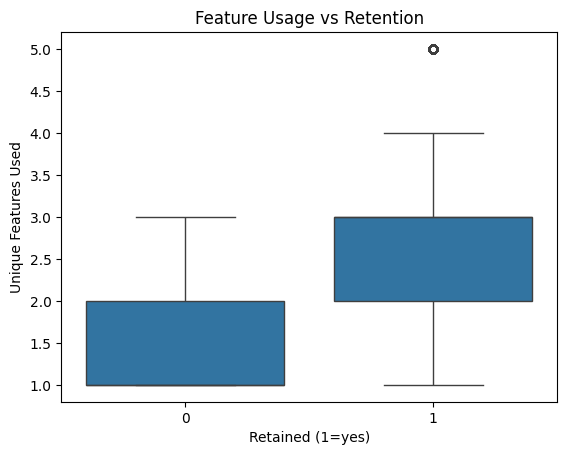

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(data=usage_summary, x="retained", y="unique_features_used")
plt.title("Feature Usage vs Retention")
plt.xlabel("Retained (1=yes)")
plt.ylabel("Unique Features Used")
plt.show()


In [16]:
usage_summary.to_csv("analysed_data/usage_summary.csv", index=False) # just storing for later usage

In [17]:
# A/B Testing
ab_test_df = run_ab_tests(funnel_df, funnel_steps)
display(ab_test_df)

,group,from_step,to_step,users_at_from_step,users_converted,conversion_rate_%,p_value
0,B,landing_page,signup,4916,4214,85.72,NaN
1,A,landing_page,signup,5084,4346,85.48,NaN
2,z-test,landing_page,signup,10000,8560,NaN,0.7366
3,B,signup,email_verified,4214,3767,89.39,NaN
4,A,signup,email_verified,4346,3944,90.75,NaN
5,z-test,signup,email_verified,8560,7711,NaN,0.0357
6,B,email_verified,onboarding_start,3767,2633,69.90,NaN
7,A,email_verified,onboarding_start,3944,2768,70.18,NaN
8,z-test,email_verified,onboarding_start,7711,5401,NaN,0.7840


In [18]:
# logging in alert file if there is an exceptional p value
alert_ab_test(ab_test_df)

Logged to alerts\slack_log_2025-07-04.txt


In [19]:
# anomaly checking with flagging
daily_df = get_daily_conversion(funnel_df, funnel_steps) # calculates each event conversion based on users on daily basis
anomalies_df = detect_anomalies(daily_df)
anomalies_flagged = anomalies_df[anomalies_df['anomaly']]

display(anomalies_flagged[['date', 'from_step', 'to_step', 'conversion_rate', '7d_avg', 'deviation', 'flag']].head())

,date,from_step,to_step,conversion_rate,7d_avg,deviation,flag
189,2025-01-09,signup,email_verified,78.26,90.635714,-12.375714,Drop
373,2025-01-12,email_verified,onboarding_start,55.10,68.242857,-13.142857,Drop
390,2025-01-29,email_verified,onboarding_start,83.33,68.268571,15.061429,Spike
397,2025-02-05,email_verified,onboarding_start,56.86,70.055714,-13.195714,Drop
240,2025-03-01,signup,email_verified,74.42,87.784286,-13.364286,Drop


In [20]:
# logging in alert file if anomaly is detected
alert_anomalies(anomalies_df)

Logged to alerts\slack_log_2025-07-04.txt
Logged to alerts\slack_log_2025-07-04.txt
Logged to alerts\slack_log_2025-07-04.txt
Logged to alerts\slack_log_2025-07-04.txt
Logged to alerts\slack_log_2025-07-04.txt
Logged to alerts\slack_log_2025-07-04.txt
Logged to alerts\slack_log_2025-07-04.txt
Logged to alerts\slack_log_2025-07-04.txt
Logged to alerts\slack_log_2025-07-04.txt
Logged to alerts\slack_log_2025-07-04.txt
Logged to alerts\slack_log_2025-07-04.txt
Logged to alerts\slack_log_2025-07-04.txt


### AUTOMATION 

- Let's say that the file is connected to a real-time dataset.
- Then we need to **run the file daily** to ensure updated metrics and alerts.
- To automate that process, we can use a Python script with the `schedule` module.

```python
import schedule
import time
import papermill as pm

def run_notebook():
    pm.execute_notebook(
        'main.ipynb',
        'executed_main.ipynb'  # output version
    )

schedule.every().day.at("08:00").do(run_flowtify) # 8 am schedule, can be changed accordingly

print("Scheduler started. Waiting for scheduled time...")

while True:
    schedule.run_pending()
    time.sleep(60)
```

